<a href="https://colab.research.google.com/github/sarunas856/final_project/blob/main/(un)like.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Duomenų rinkinys ir inspiracija

Duomenų rinkinys buvo sukurtas siekiant nustatyti, ar CNN galima išmokyti suskirstyti moterų nuotraukas į vieną iš dviejų klasių – patinka arba nepatinka. Kitais žodžiais tariant, atlikti moterų patrauklumo klasifikaciją taip, kaip žmogus ją atlieka "Tinder" programėje. Iš „Tinder“ programėlės surinkau 1000 moterų nuotraukas iš Lietuvos, kurias naudoju kaip mokymosi vaizdus. Žinoma, tai MANO patinka/nepatinka interpretacija, kuri skirsis nuo to, ką kiti gali laikyti patinkančia/nepatinkančia. Pažymėtina, kad duomenų rinkinys yra privatus dėl BDAR.

## Prepare data

In [ ]:
from pathlib import Path

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
from google.colab.patches import cv2_imshow # cv2_imshow performs convertion BGR2RGB itself

In [ ]:
def plot_classification(y_true, y_pred):
    target_names = searches
    labels_names = [0, 1] 
    print(classification_report(y_true, y_pred,labels=labels_names, target_names=target_names))    
    cm = confusion_matrix(y_true, y_pred,labels=labels_names)  #, normalize='true'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.show()


def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
searches = 'like', 'unlike'
data_dir = Path('/content/gdrive/My Drive/tinder')

In [ ]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

1000


In [ ]:
IMG_SIZE = (224, 224)

In [ ]:
# like = list(data_dir.glob('like/*'))
# im = PIL.Image.open(str(like[173]))
# im.resize(IMG_SIZE)

In [ ]:
BATCH_SIZE = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset="training",
    seed=123,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

test_dataset = val_ds.take(2)
val_ds = val_ds.skip(2)

print('Batches for testing -->', test_dataset.cardinality())
print('Batches for validating -->', val_ds.cardinality())

Found 1000 files belonging to 2 classes.
Using 750 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.
Batches for testing --> tf.Tensor(2, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(2, shape=(), dtype=int64)


In [ ]:
class_names = train_ds.class_names
print(class_names)

['like', 'unlike']


In [ ]:
# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

#### Data normalization

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

### Configure the dataset for performance



In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

#### Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1, 0.2)
])

### Create the base model from the pre-trained convnets

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)

early_stopping_monitor = EarlyStopping(patience=100, restore_best_weights=True)

total_epochs = 100

In [ ]:
def create_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

    base_model.trainable = True

    # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 140 

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # # Add a classification head
    # image_batch, label_batch = next(iter(train_ds))
    # feature_batch = base_model(image_batch)

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # feature_batch_average = global_average_layer(feature_batch)

    prediction_layer = tf.keras.layers.Dense(1)
    # prediction_batch = prediction_layer(feature_batch_average)
    # print(prediction_batch.shape)

    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.15)(x) 
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    base_learning_rate = 0.0001

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/20), #RMSprop
                metrics=['accuracy'])

    return model

In [ ]:
model = create_model()

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Number of layers in the base model:  154
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_13  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                    

In [ ]:
history = model.fit(train_ds, epochs=total_epochs, verbose=True, 
                    validation_data=val_ds, callbacks = [early_stopping_monitor])

Epoch 1/100
12/12 [==============================] - 11s 348ms/step - loss: 0.8587 - accuracy: 0.5013 - val_loss: 0.7505 - val_accuracy: 0.5278
Epoch 2/100
12/12 [==============================] - 1s 100ms/step - loss: 0.7638 - accuracy: 0.5000 - val_loss: 0.7772 - val_accuracy: 0.4861
Epoch 3/100
12/12 [==============================] - 1s 103ms/step - loss: 0.7402 - accuracy: 0.5267 - val_loss: 0.7133 - val_accuracy: 0.6250
Epoch 4/100
12/12 [==============================] - 1s 103ms/step - loss: 0.7326 - accuracy: 0.5147 - val_loss: 0.6956 - val_accuracy: 0.6111
Epoch 5/100
12/12 [==============================] - 1s 104ms/step - loss: 0.7121 - accuracy: 0.5507 - val_loss: 0.6944 - val_accuracy: 0.6250
Epoch 6/100
12/12 [==============================] - 1s 104ms/step - loss: 0.6859 - accuracy: 0.5600 - val_loss: 0.6889 - val_accuracy: 0.6389
Epoch 7/100
12/12 [==============================] - 1s 110ms/step - loss: 0.6875 - accuracy: 0.5467 - val_loss: 0.6838 - val_accuracy: 0.652

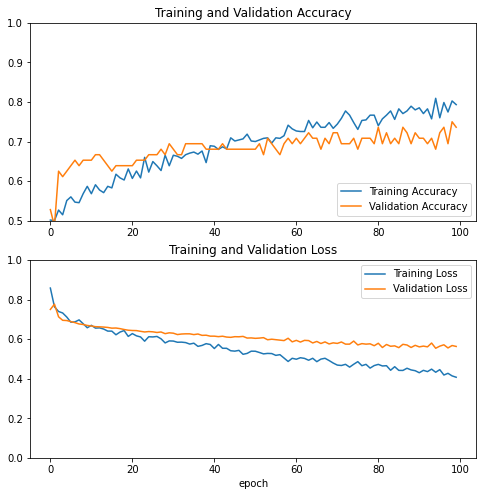

In [ ]:
plot_history(history)

# Rezultatai

*   Pritaikius skirtingus `tf.keras.applications` modulius (naudotas *Transfer learning* metodas), išsirinktas tiksliausias modelis - `MobileNet v2` - su 75% tikslumu. 
*   Kiti modeliai - `MobileNetV3Large`, `MobileNetV3Small`, `Xception` - prognozavo labai prastai, kiekvieno tikslumas siekė ~50% (*monetos metimas*).
*   `Inception V3` prognozavo 65% tikslumu.






## Pasiūlymai siekiant pagerinti tikslumą

*   pridėti kiekvienos nuotraukos atributus, t. y. prijungti lentelinius duomenis: `ar blondinė`, `ar brunetė`, `šypsena`, `daug makiažo`, etc.)
*   modeliuoti naudojant `MobileNet v2`
*   modeliuoti naudojant `Inception V3`










In [ ]:
# Save keras model in Keras H5 format. 
model_path = 'my_model.h5'
model.save(model_path)

In [ ]:
# Load keras model
model_path = 'my_model.h5'
model = tf.keras.models.load_model(model_path)

## App
https://huggingface.co/spaces/sarunas856/tinder

## Literatūra
*   https://www.tensorflow.org/api_docs/python/tf/keras/applications
*   https://www.kaggle.com/code/bmarcos/image-recognition-gender-detection-inceptionv3/notebook
*   https://github.com/giedriusblazys/SDA_DS_class
*   https://ds.en.sdacademy.pro/slides/





